In [1]:
import torch
import os
from torch.utils.cpp_extension import load

# for image manipulation
from torchvision import io

# for image display
from matplotlib import pyplot as plt


os.environ['CUDA_LAUNCH_BLOCKING']='1'

In [2]:
%load_ext wurlitzer

### Simple addition Kernel

In [3]:
addition_module = load(
    name="add",
    sources=["csrc/add.cu"], 
    extra_cuda_cflags=["-O2", "-Xcompiler", "-Werror", "-Xcompiler", "-Wall"], 
    verbose=True
)

Using /home/ganesh/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/ganesh/.cache/torch_extensions/py310_cu121/add/build.ninja...
Building extension module add...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module add...


In [4]:
gen = torch.Generator(device='cuda')
gen.manual_seed(42)

a = torch.randn(size=(1000000, 10), dtype=torch.float32, device='cuda:0', generator=gen).contiguous()
b = torch.randn(size=(1000000, 10), dtype=torch.float32, device='cuda:0', generator=gen).contiguous()

In [5]:
%time

c = a + b

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.68 µs


In [6]:
%time 

c_cuda = addition_module.add(a, b)

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 7.87 µs
n: 10000000


In [7]:
c_cuda.shape

torch.Size([1000000, 10])

In [8]:
torch.testing.assert_close(c, c_cuda)

### Grey Scale Image

The image is parsed as one long vector. CUDA parses it in row-major. 

![Row Major Example](row_major_example.png)

Note that in pytorch, we have CxHxW which is essentially row major and the channels being first can be handled as needed in the kernel.

##### Method 1 - Using a CUDA kernel that uses threads arranged in 1D

puppy.shape = torch.Size([3, 1330, 1920]), puppy.dtype = torch.uint8


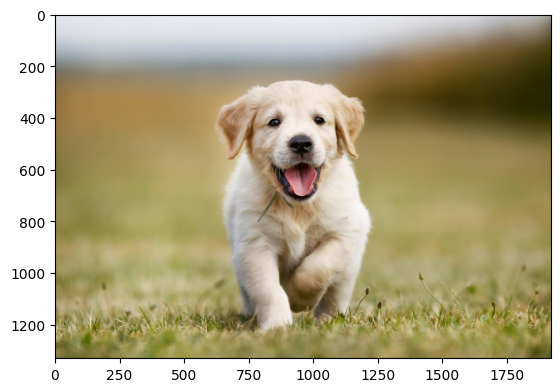

In [9]:
puppy = io.read_image('puppy.jpg')
print(f"{puppy.shape = }, {puppy.dtype = }")
_ = plt.imshow(puppy.permute(1, 2, 0).cpu()) # because torch loads as (C, H, W)

In [10]:
image_manip_module = load(
    name="ops",
    sources=["csrc/image_manip.cu"], 
    extra_cuda_cflags=["-O2", "-Xcompiler", "-Werror", "-Xcompiler", "-Wall"], 
    verbose=True
)

Using /home/ganesh/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/ganesh/.cache/torch_extensions/py310_cu121/ops/build.ninja...
Building extension module ops...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/2] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output image_manip.cuda.o.d -DTORCH_EXTENSION_NAME=ops -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /home/ganesh/.local/share/virtualenvs/cudamode-lectures-SlOoH9rC/lib/python3.10/site-packages/torch/include -isystem /home/ganesh/.local/share/virtualenvs/cudamode-lectures-SlOoH9rC/lib/python3.10/site-packages/torch/include/torch/csrc/api/include -isystem /home/ganesh/.local/share/virtualenvs/cudamode-lectures-SlOoH9rC/lib/python3.10/site-packages/torch/include/TH -isystem /home/ganesh/.local/share/virtualenvs/cudamode-lectures-SlOoH9rC/lib/python3.10/site-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /home/ganesh/.pyenv/versions/3.10.13/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=0 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_N

Loading extension module ops...


In [11]:
%time
grey_image_1d_op = image_manip_module.ops.grey_scale_1d(puppy.to('cuda:0').contiguous())

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 7.39 µs


grey_image_1d_op.shape = torch.Size([1330, 1920]), grey_image_1d_op.dtype = torch.uint8


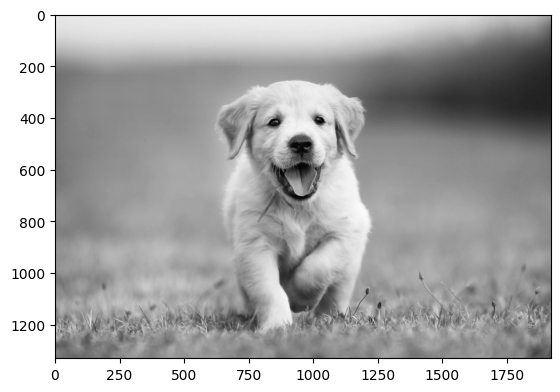

In [12]:
print(f"{grey_image_1d_op.shape = }, {grey_image_1d_op.dtype = }")
_ = plt.imshow(grey_image_1d_op.cpu(), cmap='gray')

##### Method 2 - Using a CUDA kernel that uses threads arranged in 2D


In [13]:
%time

grey_image_2d_op = image_manip_module.ops.grey_scale_2d(puppy.to('cuda:0').contiguous())

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 7.15 µs


grey_image_2d_op.shape = torch.Size([1330, 1920]), grey_image_2d_op.dtype = torch.uint8


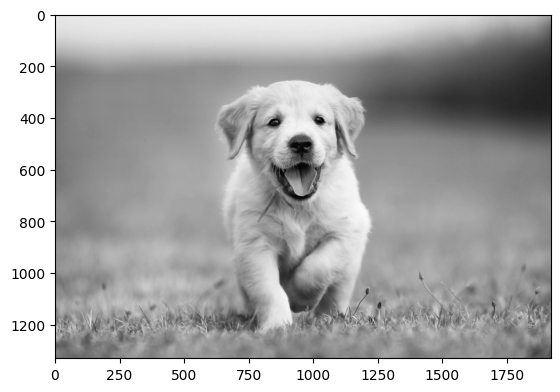

In [14]:
print(f"{grey_image_2d_op.shape = }, {grey_image_2d_op.dtype = }")
_ = plt.imshow(grey_image_2d_op.cpu(), cmap='gray')

In [15]:
torch.testing.assert_close(grey_image_1d_op, grey_image_2d_op)